In [2]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import curve_fit
import glob

#Note this noteboook makes use of the following data - this makes it more or less a test. Can be changed later.
time = np.load('times-year.npy')
particles = np.load('n-bound.npy')

def chi2(O,E):
    return np.sum(np.square(O - E) / E)

In [3]:
import os
print(os.getcwd())
print(os.path.isdir('images-MAcrit'))
os.chdir('..')
print(os.getcwd())
print(os.path.isdir('images-MAcrit'))

/home/vdvuurst/AMUSE/amuse-KL
False
/home/vdvuurst/AMUSE
True


Number of particles halved at t = 17058 yr, with Rhalf = 8.285302445590116 AU


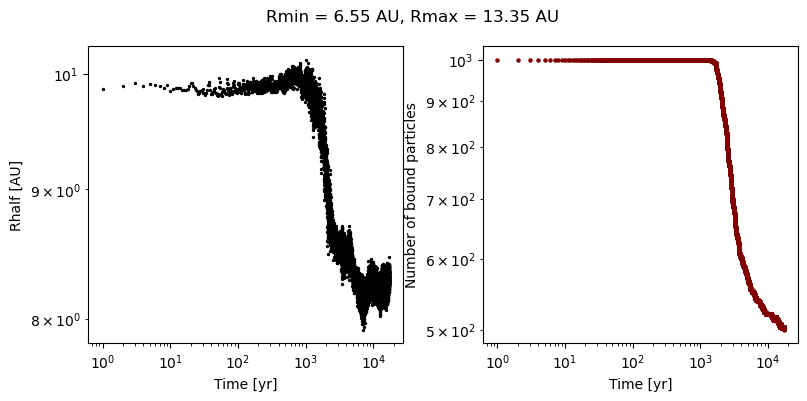

Number of particles halved at t = 24640 yr, with Rhalf = 8.425587719708682 AU


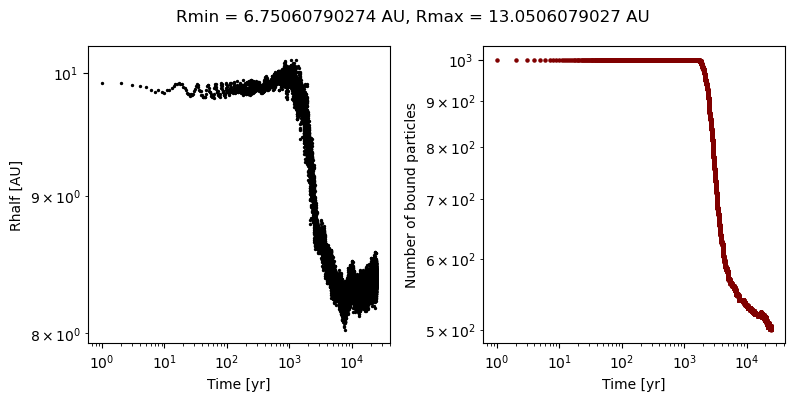

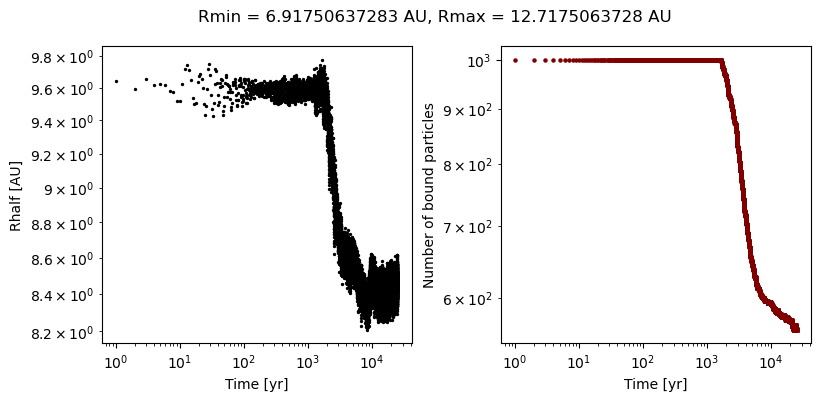

In [ ]:
#Testing 25k year data
Rhalf_glob = glob.glob('Rhalf_*.npy')
Nbound_glob = glob.glob('Nbound_*.npy')
for Rhalf_file,Nbound_file in zip(sorted(Rhalf_glob),sorted(Nbound_glob)):
    Rmin,Rmax = Rhalf_file.strip('.npy').split('_')[1].split('-')
    if 'au' in Rmax:
        Rmax = Rmax.strip(' au ')
    if 'au' in Rmin:
        Rmin = Rmin.strip(' au ')
    Rmin,Rmax = float(Rmin),float(Rmax)
    Rhalf,Nbound = np.load(Rhalf_file),np.load(Nbound_file)
    time = np.arange(Rhalf.shape[0],step=1)
    
    try:
        print(f'Number of particles halved at t = {time[Nbound == 500][0]} yr, with Rhalf = {Rhalf[Nbound == 500][0]} AU')
    except IndexError:
        pass #Nbound wasnt halved
    
    fig,ax = plt.subplots(ncols=2,figsize=(8,4))
    fig.suptitle(f'{Rmin = } AU, {Rmax = } AU')
    ax[0].scatter(time,Rhalf,s=2,c='black')
    ax[1].scatter(time,Nbound,s=5,c='maroon')
    ax[0].set(xlabel='Time [yr]',ylabel='Rhalf [AU]')
    ax[1].set(xlabel='Time [yr]',ylabel='Number of bound particles')
    fig.tight_layout()
    ##UNCOMMENT if you want loglog plots
    # ax[0].loglog()
    # ax[1].loglog()
    plt.show()

## Fitting a power law in log-space

WORKING ON Nbound_6.91750637283 au-12.7175063728 au.npy
chi2 (log): 5.909877602074204
chi2 : 63759.66126806356


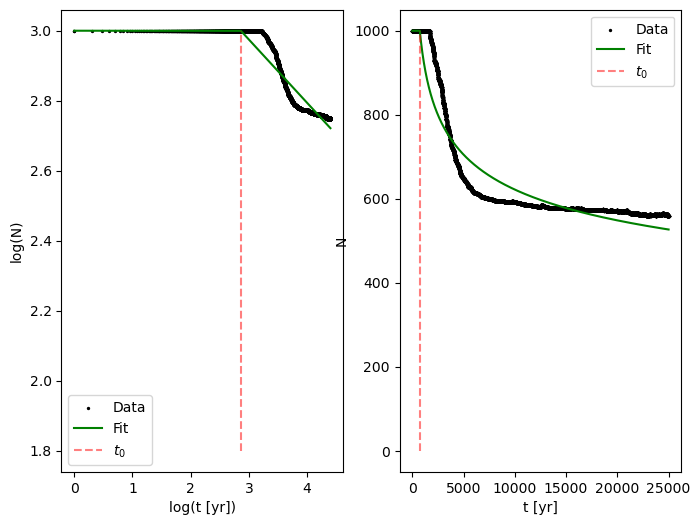

log(t0) = 2.859381226159168 ± 0.0032361871019994824 ----> t_0 = 723.4045335787441 ± 0.01744472630827405
alpha = -0.18095856320602183 ± 0.0004882310381189901

WORKING ON Nbound_6.75060790274 au-13.0506079027 au.npy
chi2 (log): 9.9655064310041
chi2 : 105560.98232177245


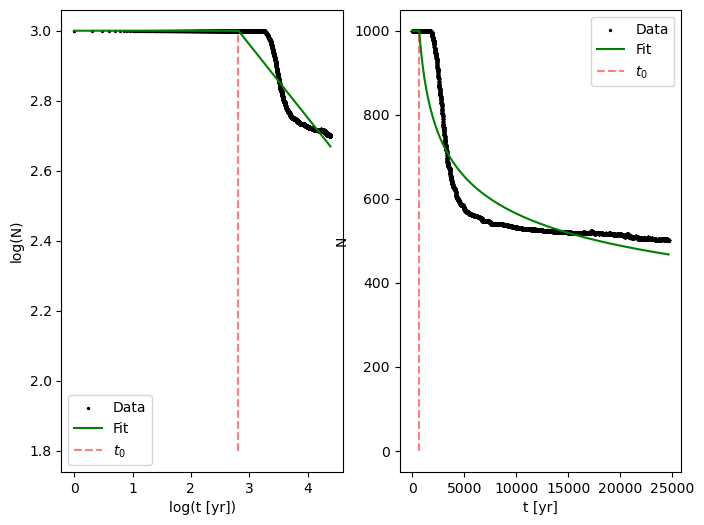

log(t0) = 2.815067935967778 ± 0.0037202464792187133 ----> t_0 = 653.2327287714043 ± 0.020817427142043637
alpha = -0.20957260942606215 ± 0.0006315902417160824

WORKING ON Nbound_6.55-13.35.npy
chi2 (log): 5.529372472665519
chi2 : 57017.434759783275


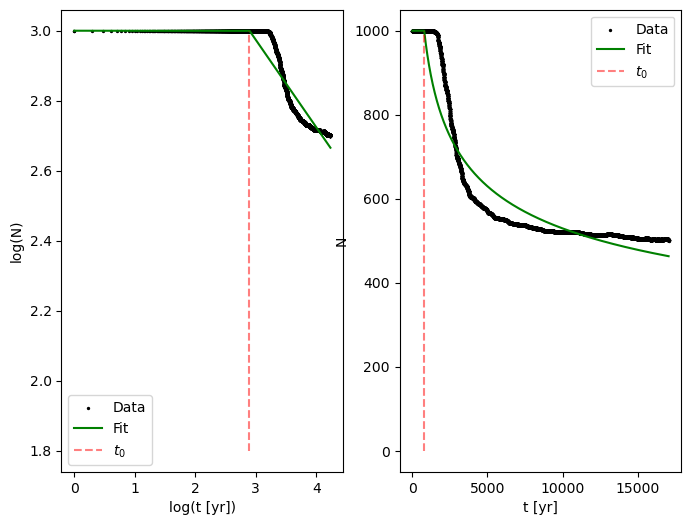

log(t0) = 2.8953232193051113 ± 0.003068997780366298 ----> t_0 = 785.820255864694 ± 0.01704245110463592
alpha = -0.2500923898260824 ± 0.0007551779881764141



In [37]:
for Nbound_file in Nbound_glob: 
    print(50*'==')
    print(f'WORKING ON {Nbound_file}')
    particles = np.load(Nbound_file)
    time = np.arange(particles.shape[0],step=1)
    # halflifemask = particles > 0.5*np.max(particles)
    # particles = particles[halflifemask] #up until halving point
    # time = time[halflifemask]

    logtime = np.log10(time,where = time != 0) #where arg to avoid nans
    logparticles = np.log10(particles)

    ################################################################################
    # In case b is fittable (it shouldn't be since initial number of particles is known)

    # def _linear_with_b(logt,t_0,alpha,b):
    #     return alpha*(logt-t_0) + b

    # def constant_linear_with_b(logt,t_0,alpha,b):
    #     trel = logt - t_0 
    #     constant = lambda x: np.full(x.shape,b) #x is time here
    #     lin = lambda x: _linear_with_b(x,t_0,alpha,b)
    #     function = np.piecewise(logt, [trel <= 0, trel > 0],[constant,lin])
    #     return function

    # popt,pcov = curve_fit(constant_linear_with_b,logtime,logparticles,p0=[logtime[1289],-1.7,3]) 

    ################################################################################

    def _linear(logt,t_0,alpha):
        return alpha*(logt-t_0) + 3

    def constant_linear(logt,t_0,alpha):
        trel = logt - t_0 
        constant = lambda x: np.full(x.shape,3) #x is time here
        lin = lambda x: _linear(x,t_0,alpha)
        function = np.piecewise(logt, [trel <= 0, trel > 0],[constant,lin])
        return function

    popt,pcov = curve_fit(constant_linear,logtime,logparticles,p0=[logtime[1289],-1.7],maxfev=5000)

    pred = constant_linear(logtime,*popt)

    print(f'chi2 (log): {chi2(logparticles,pred)}')
    print(f'chi2 : {chi2(particles,10**pred)}')

    fig,(ax0,ax1) = plt.subplots(ncols=2,figsize=(8,6))
    ax0.scatter(logtime,logparticles,c='black',label='Data',s=2)
    ax0.plot(logtime,pred,label='Fit',c='Green')
    ax0.vlines(popt[0],1.8,3,colors='red',label=r'$t_0$',linestyles='dashed',alpha=0.5)
    ax0.legend()
    ax0.set_ylabel('log(N)')
    ax0.set_xlabel('log(t [yr])')
    # plt.show()
    # plt.figure()
    ax1.scatter(time,particles,c='black',label='Data',s=2)
    ax1.plot(time,10**pred,label='Fit',c='Green')
    ax1.vlines(10**popt[0],0,1000,colors='red',label=r'$t_0$',linestyles='dashed',alpha=0.5)
    ax1.legend()
    ax1.set_ylabel('N')
    ax1.set_xlabel('t [yr]')
    plt.show()

    print(f"log(t0) = {popt[0]} ± {np.sqrt(pcov[0,0])} ----> t_0 = {10**popt[0]} ± {10**popt[0]*np.log(10)*pcov[0,0]}")
    print(f"alpha = {popt[1]} ± {np.sqrt(pcov[1,1])}")
    try:
        print(f"b = {popt[2]} ± {np.sqrt(pcov[2,2])}")
    except IndexError:
        pass

    print()

## Fitting an exponential (not as good)

Chi2 : 134682.33479129148


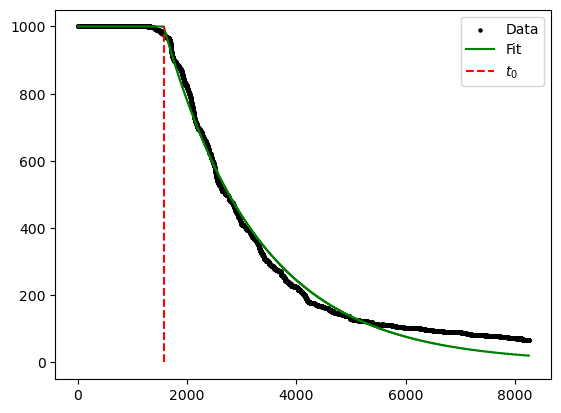

t0 = 1572.9008867518614 ± 2.284276553461934
tau = 1728.7089233763745 ± 3.258832542305948


In [3]:

def _exp_decay(t,t0,tau):
    return 1000 * np.exp( - (t - t0) / tau) + 0


def _const_exp_decay(t,t0,tau):
    trel = t - t0
    constant = lambda t: np.full(t.shape,1000)
    exp_function = lambda t: _exp_decay(t,t0,tau)
    function = np.piecewise(t, [trel <= 0, trel > 0],[constant,exp_function])
    return function

def exp_decay_fit(t,t0,tau):#for now we are not fitting on amp or offset
    return _const_exp_decay(t,t0,tau)

popt,pcov = curve_fit(exp_decay_fit,time,particles,maxfev=5000)

pred = _const_exp_decay(time,*popt)

print(f'Chi2 : {chi2(particles,pred)}')


plt.figure()
plt.scatter(time,particles,c='black',label='Data',s=5)
plt.plot(time,pred,label='Fit',c='Green')
plt.vlines(popt[0],0,1000,colors='red',label=r'$t_0$',linestyles='dashed')
plt.legend()
plt.show()

print(f"t0 = {popt[0]} ± {np.sqrt(pcov[0,0])}")
print(f"tau = {popt[1]} ± {np.sqrt(pcov[1,1])}")

### Without t0 as a fittable parameter

t0 = np.int64(1290)


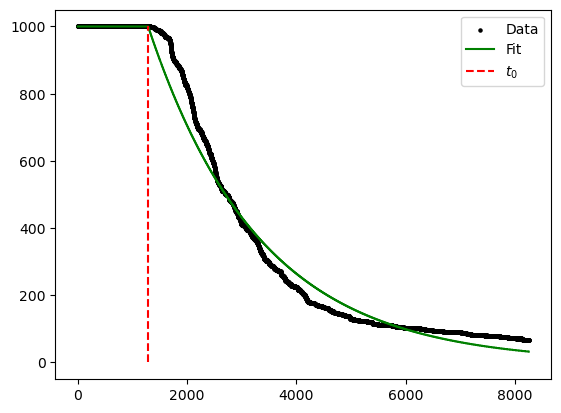

tau = 2040.322147912193 ± 3.874193572060909


In [4]:
t0 = time[particles < 1000][0]
print(f'{t0 = }')

def _exp_decay(t,tau):
    return 1000 * np.exp( - (t - t0) / tau) + 0


def _const_exp_decay(t,tau):
    trel = t - t0
    constant = lambda t: np.full(t.shape,1000)
    exp_function = lambda t: _exp_decay(t,tau)
    function = np.piecewise(t, [trel <= 0, trel > 0],[constant,exp_function])
    return function

def exp_decay_fit(t,tau):#for now we are not fitting on amp or offset
    return _const_exp_decay(t,tau)

popt,pcov = curve_fit(exp_decay_fit,time,particles)

plt.figure()
plt.scatter(time,particles,c='black',label='Data',s=5)
plt.plot(time,_const_exp_decay(time,*popt),label='Fit',c='Green')
plt.vlines(t0,0,1000,colors='red',label=r'$t_0$',linestyles='dashed')
plt.legend()
plt.show()

# print(f"t0 = {popt[0]} ± {np.sqrt(pcov[0,0])}")
print(f"tau = {popt[0]} ± {np.sqrt(pcov[0,0])}")